In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot
import matplotlib.pyplot as plt
import warnings
import itertools
import datetime
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import sys

C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
class TGIM_Model(object):
    def __init__(self):
        
        #Class constructor or initialization method.''''''
        earth = "blue"
        
    def get_data(self, data):
        #data= pd.read_csv(r"C:\Users\1004365\Desktop\Ajith TCS Internal\TGIM\\CPU_LOAD_OLD.csv")
        data_copy = data.copy()
        print("Top two columns of data set")
        print("\n")
        print(data_copy.head(2))
        print("\n")
        print("\n")
        print("Columns",data_copy.columns)
        
        #convert dataframe into time series
        data_copy['Date'] = pd.to_datetime(data_copy['Date'])
        
        ###################### getting basic statistics  ###############################
        print("The statistical analysis on data set \n")
        print("\n")
        print(data_copy.describe())
        data_copy.index = data_copy['Date']
        data_copy.index =data_copy.index.map(lambda t: t.strftime('%Y-%m-%d %H:%M'))
        data_copy['no_seconds'] = data_copy.index
        #
        data_copy['Day/Month/Year'] = data_copy['Date'].apply(lambda x: "%d/%d/%d" % (x.day,x.month, x.year))
        print("\n")
        print("\n")
        print("The number samples per each day on original data\n")
        print(pd.value_counts(data_copy['Day/Month/Year'], sort = True))
        #
        #create a new time series
        times = pd.date_range('2017-07-16 00:02:00 ', periods=9216, freq='5min')

        times_df = pd.DataFrame()
        times_df["series"] = times
        times_df.index= times_df["series"]
        times_df.index =times_df.index.map(lambda t: t.strftime('%Y-%m-%d %H:%M'))
        times_df['no_seconds'] = times_df.index
        #
        mergerd = pd.merge(times_df, data_copy, on='no_seconds', how= 'outer')
        print("\n")
        print("\n")
        print("Newly merged data frame which contains newly for time stamps")
        print(mergerd.head(3))
        del mergerd['series']
        del mergerd['Day/Month/Year']
        mergerd['no_seconds'] = pd.to_datetime(mergerd['no_seconds'])
        mergerd.index = mergerd.no_seconds
        mergerd = mergerd.sort_index() 
        values = mergerd.groupby(pd.TimeGrouper('5Min'))['Value'].sum()
        #
        print("\n")
        print("\n")
        print("After sorting time indices and wrapping to 5min time stamp")
        print(values.shape)
        train_df = pd.DataFrame()
        train_df['values'] = values
        train_df['Date'] = train_df.index
        train_df['Date'] = pd.to_datetime(train_df['Date'])
        train_df['Day/Month/Year'] = train_df['Date'].apply(lambda x: "%d/%d/%d" % (x.day,x.month, x.year))
        print("\n")
        print("\n")
        print("Now check for missing time stamps, there are no missing timeslots")
        print(pd.value_counts(train_df['Day/Month/Year'], sort = True))
        print("missing values at different times")
        print(train_df.apply(lambda x: sum(x.isnull())))
        y = train_df['values']
        nan_index = list(y[np.isnan(y.values)].index)

        for dIndex in nan_index:
            upper = dIndex + datetime.timedelta(minutes=5)
            lower = dIndex - datetime.timedelta(minutes=5)
    
            while(np.isnan(y[upper])):
                upper = upper + datetime.timedelta(minutes=5)
            while(np.isnan(y[lower])):
                lower = lower - datetime.timedelta(minutes=5)
            y[dIndex] = (y[upper] + y[lower])/2
        
        #delete un used variables
        del times_df, data_copy, data,mergerd
        Dummy_df = pd.DataFrame(y)
        print("\n")
        print("\n")
        print("Missing values after imputation with average of above and below values")
        print(Dummy_df.apply(lambda x: sum(x.isnull())))
        del Dummy_df
        return y
    #
    #
    def decomposeSeries(self, series, period=288):
        decomposedSeries = sm.tsa.seasonal_decompose(series,freq=period)
        season = decomposedSeries.seasonal
        series_new = series - season
        latest_date = season.index.date[-1]
        season_pre = season[str(latest_date)]
        season_pre.index = season_pre.index + datetime.timedelta(days=1)
        #print("\n")
        #print("\n")
        #print(len(season_pre))
        return series_new,season_pre

    #Dickey Fuller Test of Stationarity-
    def testStationarity(self, series):
        result = adfuller(series)
        print("\n")
        print("\n")
        print("Dickey Fuller Test of Stationarity")
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        print("\n")
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
                            
    def findOrder(self, series, p=1,d=1,q=1):
        p = range(p)
        d = range(d)
        q = range(q)
        orderList = list(itertools.product(p, d, q))
        AIC = []
        minAIC = sys.maxsize
        selOrder = (0,0,0)
        for order in orderList:
            try:
                print("processing order {}".format(order))
                model = ARIMA(series, order=order)
                model_fit = model.fit(disp=0)
                print("Order {} AIC {} BIC {}".format(order,model_fit.aic,model_fit.bic))
                AIC.append(model_fit.aic)
                if(model_fit.aic < minAIC):
                    minAIC = model_fit.aic
                    selOrder = order
            except:
                continue
        return selOrder

    def doArima(self, series,order):
        model = ARIMA(series, order=order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        return np.squeeze(yhat)
     
    def forecast_plot(self, y_decomp, y, season,order):
        for i in range(1):  
            train_size = int(len(y) - 288 + i*12)
            y_new = y_decomp.copy()
            y_new = y_new.append((y[len(y_decomp):train_size] - season).dropna())
            test = y[train_size:train_size+30]
            #print(y_new[-1])
            history = [x for x in y_new]
            predictions = list()
            for t in range(30):
                print("\n")
                print(t)
                yhat = self.doArima(history,order)
                predictions.append(yhat)
                history.append(yhat)
                print("Predicted : {} Actual:{}".format(np.round(np.squeeze(yhat),2)+np.round(season[t+i*12],2),np.round(test[t],2)))

            test_act = test[:30]
            test_pre = pd.Series(np.squeeze(predictions),index = test_act.index) + season[i*12:i*12+30]
            print("season")
            print(season[i*12:i*12+30])
            print("\n")
            print("Actual", test_act)
            print("\n")
            print("Predicted", test_pre)
            print("\n")
            plt.plot(test_act)
            plt.plot(test_pre)
            plt.legend(["Actuals","Predicted"])
            plt.xlabel('Date & Time')
            plt.ylabel('CPU LOAD')
            plt.show()
        

In [3]:
def main():
    obj = TGIM_Model()
    data= pd.read_csv(r"C:\Users\1004365\Desktop\Ajith TCS Internal\TGIM\\CPU_LOAD_OLD.csv")
    y = obj.get_data(data)
    train_size = int(len(y) - 288)
    train = y[0:train_size]
    y_decomp, season = obj.decomposeSeries(train)
    obj.testStationarity(y_decomp)
    order = obj.findOrder(y_decomp)
    print("_________________________________________________________________________")
    print("\n")
    print("The order is",order)
    obj.forecast_plot( y_decomp,y, season,order)
    
    

Top two columns of data set


                  Date  Value
0  2017-07-16 00:02:45   0.89
1  2017-07-16 00:07:45   0.64




Columns Index(['Date', 'Value'], dtype='object')
The statistical analysis on data set 



             Value
count  9183.000000
mean      1.252883
std       0.854700
min       0.150000
25%       0.660000
50%       0.960000
75%       1.580000
max       5.920000




The number samples per each day on original data

16/8/2017    288
18/7/2017    288
3/8/2017     288
5/8/2017     288
12/8/2017    288
16/7/2017    288
19/7/2017    288
20/7/2017    288
28/7/2017    288
6/8/2017     288
4/8/2017     288
24/7/2017    288
10/8/2017    288
7/8/2017     288
22/7/2017    288
29/7/2017    288
25/7/2017    288
23/7/2017    288
15/8/2017    288
17/7/2017    288
2/8/2017     288
8/8/2017     288
13/8/2017    288
9/8/2017     288
30/7/2017    288
14/8/2017    288
1/8/2017     288
21/7/2017    287
26/7/2017    287
11/8/2017    287
31/7/2017    275
27/7/2017    271
Name: Day/Month/Y

C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy






Missing values after imputation with average of above and below values
values    0
dtype: int64




Dickey Fuller Test of Stationarity
ADF Statistic: -11.482147
p-value: 0.000000
Critical Values:


	1%: -3.431
	5%: -2.862
	10%: -2.567
processing order (0, 0, 0)
Order (0, 0, 0) AIC 12810.60571745166 BIC 12824.799612820903
_________________________________________________________________________


The order is (0, 0, 0)


0
Predicted : 1.0 Actual:0.9


1
Predicted : 0.9299999999999999 Actual:1.38


2
Predicted : 0.9099999999999999 Actual:1.1


3
Predicted : 0.85 Actual:0.91


4
Predicted : 0.9099999999999999 Actual:0.76


5
Predicted : 0.94 Actual:0.76


6


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages

Predicted : 1.44 Actual:1.26


7
Predicted : 1.37 Actual:1.06


8
Predicted : 1.15 Actual:1.25


9
Predicted : 0.89 Actual:0.72


10
Predicted : 0.87 Actual:1.42


11


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages

Predicted : 1.06 Actual:1.02


12
Predicted : 1.29 Actual:1.02


13
Predicted : 1.16 Actual:0.81


14
Predicted : 1.1 Actual:0.71


15
Predicted : 0.89 Actual:0.47


16
Predicted : 0.87 Actual:0.75


17
Predicted : 0.87 Actual:0.51


18
Predicted : 0.95 Actual:0.86


19
Predicted : 1.01 Actual:0.74


20
Predicted : 0.9099999999999999 Actual:0.62


21
Predicted : 0.9 Actual:0.75


22
Predicted : 0.99 Actual:0.76


23
Predicted : 0.8300000000000001 Actual:1.38


24
Predicted : 1.08 Actual:1.07


25
Predicted : 1.58 Actual:1.3


26
Predicted : 1.87 Actual:1.66


27
Predicted : 1.83 Actual:1.53


28
Predicted : 1.94 Actual:1.92


29
Predicted : 1.94 Actual:2.28
season
no_seconds
2017-08-16 00:00:00   -0.251070
2017-08-16 00:05:00   -0.316091
2017-08-16 00:10:00   -0.343128
2017-08-16 00:15:00   -0.395869
2017-08-16 00:20:00   -0.337942
2017-08-16 00:25:00   -0.312973
2017-08-16 00:30:00    0.187000
2017-08-16 00:35:00    0.123620
2017-08-16 00:40:00   -0.098751
2017-08-16 00:45:00   -0.358

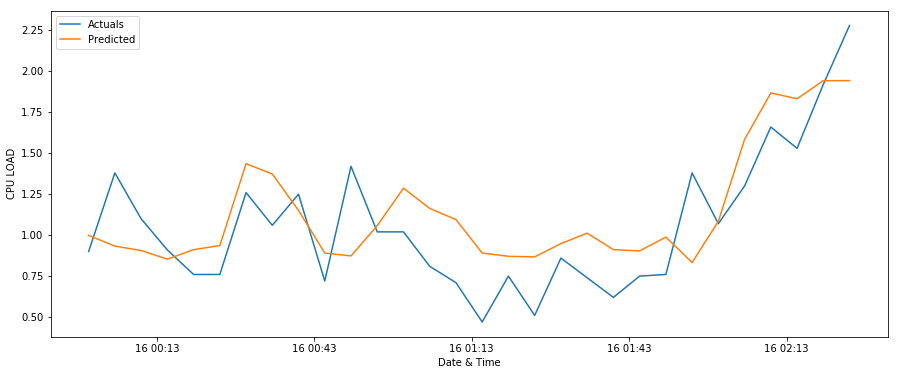

In [4]:
if __name__ == "__main__":
    # calling main function
    main()